In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
# to split dataset
from sklearn.model_selection import train_test_split
# to import dataset
from sklearn.datasets import fetch_lfw_people
%matplotlib inline
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

In [2]:
# # # Cell to add mirrored images to the dataset

# from PIL import Image
# from PIL import ImageOps

# path = "./data/new_full_lfw/"
# my_list = os.listdir(path)
# # print(my_list)
# file_index = 0
# for person in my_list:
#     print(person)
#     path_of_person = path+person+"/"
#     # print(path_of_person)
#     list_of_files = os.listdir(path_of_person)
#     # print(list_of_files)
#     for file in list_of_files:
#         path_of_img = path_of_person+file
#         img = Image.open(path_of_img)
#         new_img = ImageOps.mirror(img)
#         new_img.save(path_of_img[:-4]+"_mirrored"+path_of_img[-4:])


In [3]:
import shutil
import os
path = "./data/new_full_lfw/"
val_path = "./data/val_lfw/"
my_list = os.listdir(path)
# print(my_list)
for folder in my_list:
    list_of_files = os.listdir(path+folder)
    if len(list_of_files) <= 80:
        shutil.rmtree(path + folder)
        shutil.rmtree(val_path + folder)
my_list = os.listdir(path)
# print(my_list)

In [4]:
# # cell to make my own validation set in another directory
# from PIL import Image
# val_path = "./data/val_lfw/"
# validation_split = 0.2
# for folder in my_list:
#     list_of_files = os.listdir(path+folder)
#     # will be at least 3 files in there
#     new_path = folder
#     new_path = val_path+new_path
#     os.mkdir(new_path)
#     first_img_path = path+folder+"/"+list_of_files[0]
#     img = Image.open(first_img_path)
#     img.save(new_path+"/"+list_of_files[0])
#     os.remove(path + folder + "/" + list_of_files[0])
#     for i in range(1,len(list_of_files)):
#         s = np.random.uniform(0,1,1).squeeze()
#         if s <= 0.2:
#             img_path = path+folder+"/"+list_of_files[i]
#             img = Image.open(img_path)
#             img.save(new_path+"/"+list_of_files[i])
#             os.remove(path + folder + "/" + list_of_files[i])

In [5]:
# # Cell to change images by images of zoomed faces

# from PIL import Image
# from mtcnn.mtcnn import MTCNN
# # Initialize mtcnn detector
# detector = MTCNN()
# border_rel = 0 # increase or decrease zoom on image
# path = "./data/val_lfw/"
# my_list = os.listdir(path)
# # print(my_list)
# file_index = 0
# for person in my_list:
#     print(person)
#     path_of_person = path+person+"/"
#     # print(path_of_person)
#     list_of_files = os.listdir(path_of_person)
#     # print(list_of_files)
#     for file in list_of_files:
#         # if file[0]+file[1]+file[2] < 'Jon':
#         #     continue
#         file_index+=1
#         print(file_index)
#         path_of_img = path_of_person+file
#         img = Image.open(path_of_img)
#         img = np.asarray(img, dtype='uint8')
#         detections = detector.detect_faces(img)
#         x1, y1, width, height = detections[0]['box']
#         dw = round(width * border_rel)
#         dh = round(height * border_rel)
#         x2, y2 = x1 + width + dw, y1 + height + dh
#         face = img[y1:y2, x1:x2]
#         face = Image.fromarray(face)
#         face = face.resize((224, 224))
#         face = np.asarray(face)
#         data = Image.fromarray(face) 
#         # saving the final output 
#         # as a PNG file
#         data.save(path_of_img)


In [6]:
# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)
# # data_git for when on macbook
# directory = "./data/new_full_lfw/"
# train_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.2,
#                                              subset='training',
#                                              seed = 42)
#                                             #  seed = 42
# validation_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.2,
#                                              subset='validation',
#                                              seed = 42)
#                                             #  seed = 42

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
# data_git for when on macbook
directory = "./data/new_full_lfw/"
val_directory = "./data/val_lfw/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0,
                                             seed = 42)
                                            #  seed = 42
validation_dataset = image_dataset_from_directory(val_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0,
                                             seed = 42)
                                            #  seed = 42

Found 2424 files belonging to 11 classes.
Found 293 files belonging to 11 classes.


In [8]:
classes = 5749

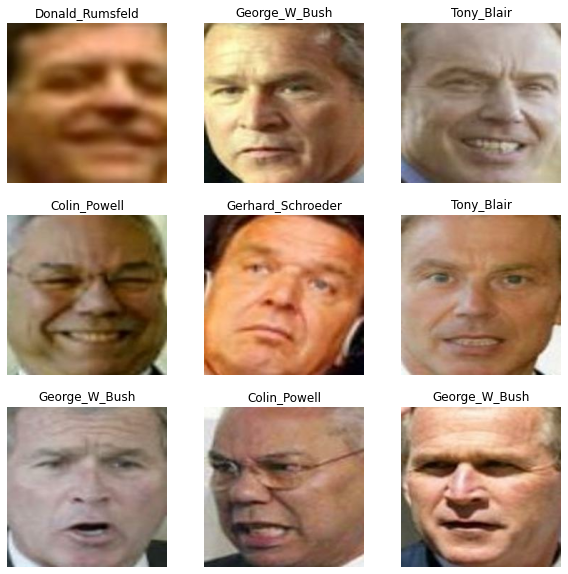

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(layers.experimental.preprocessing.RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [11]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE, IMG_SIZE)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

(224, 224, 3) (224, 224)


In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [15]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 1, 8, 5, 6, 1, 5, 2, 3, 3, 1, 1, 4, 6, 3, 3, 9, 9, 1, 3, 3, 7,
       5, 9, 3, 4, 3, 3, 3, 6, 3, 9])>

In [16]:
# base_model.trainable = False
# image_var = tf.Variable(preprocess_input(image_batch))
# pred = base_model(image_var)

# tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

In [17]:
def celeb_model(image_shape=IMG_SIZE,  data_augmentation=data_augmenter()):
    ''' Defines a tf.keras model for multiclass classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False


    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    # x = layers.Dense(256, activation = 'relu')(x)
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = layers.Dropout(0.2)(x)

    # x = layers.Dense(512, activation = "relu")(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(1024, activation = "relu")(x)
    # x = layers.Dropout(0.2)(x)

    # x = layers.Flatten(name='flatten')(x)
    out = layers.Dense(11, name='classifier')(x)
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    # outputs = layers.Dense(2, activation = "softmax")(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, out)

    
    
    return model

In [18]:
model2 = celeb_model()

In [19]:
base_learning_rate = 0.001
# optimizer = keras.optimizers.SGD(momentum=0.01)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [20]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
76/76 [==============================] - 75s 966ms/step - loss: 1.6129 - accuracy: 0.6572 - val_loss: 0.6541 - val_accuracy: 0.8225
Epoch 2/5
76/76 [==============================] - 73s 963ms/step - loss: 0.2454 - accuracy: 0.9290 - val_loss: 0.5337 - val_accuracy: 0.8703
Epoch 3/5
76/76 [==============================] - 73s 963ms/step - loss: 0.1501 - accuracy: 0.9579 - val_loss: 0.5297 - val_accuracy: 0.8601
Epoch 4/5
76/76 [==============================] - 73s 967ms/step - loss: 0.1071 - accuracy: 0.9707 - val_loss: 0.5202 - val_accuracy: 0.8703
Epoch 5/5
76/76 [==============================] - 73s 966ms/step - loss: 0.1006 - accuracy: 0.9740 - val_loss: 0.4809 - val_accuracy: 0.8908


In [21]:
class_names

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Jean_Chretien',
 'John_Ashcroft',
 'Junichiro_Koizumi',
 'Tony_Blair',
 'Vladimir_Putin']

In [22]:
# UNQ_C3
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=0.1*base_learning_rate)
tf.keras.optimizers.SGD(
    learning_rate=0.001)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = "adam", 
              metrics=metrics)

Number of layers in the base model:  177


In [23]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=validation_dataset)

Epoch 6/10
76/76 [==============================] - 75s 963ms/step - loss: 0.0389 - accuracy: 0.9934 - val_loss: 0.4598 - val_accuracy: 0.8805
Epoch 7/10
76/76 [==============================] - 73s 961ms/step - loss: 0.0376 - accuracy: 0.9926 - val_loss: 0.4246 - val_accuracy: 0.8942
Epoch 8/10
76/76 [==============================] - 73s 962ms/step - loss: 0.0254 - accuracy: 0.9979 - val_loss: 0.4087 - val_accuracy: 0.8976
Epoch 9/10
76/76 [==============================] - 73s 965ms/step - loss: 0.0266 - accuracy: 0.9967 - val_loss: 0.4082 - val_accuracy: 0.9078
Epoch 10/10
76/76 [==============================] - 73s 965ms/step - loss: 0.0271 - accuracy: 0.9959 - val_loss: 0.4130 - val_accuracy: 0.8942


In [24]:
print(model2.evaluate(train_dataset))
print(model2.evaluate(validation_dataset))

76/76 [==============================] - 65s 859ms/step - loss: 0.0079 - accuracy: 1.0000
[0.007859695702791214, 1.0]
10/10 [==============================] - 8s 775ms/step - loss: 0.4130 - accuracy: 0.8942
[0.4129844605922699, 0.894197940826416]


In [26]:
model2.save("models/11_classes_resnet50_0.89acc")

INFO:tensorflow:Assets written to: models/11_classes_resnet50_0.89acc\assets


INFO:tensorflow:Assets written to: models/11_classes_resnet50_0.89acc\assets
